## L.A. homeless arrests analysis

By [Christine Zhang](mailto:ychristinezhang@gmail.com)

The Los Angeles Times analyzed daily arrest logs between January 1, 2011 and December 31, 2016 from the LAPD to determine yearly trends in arrests of homeless people.

The results were reported in a February 4, 2018, Los Angeles Times story titled ["L.A. leaders oppose 'criminalizing' homeless people. But thousands are jailed for minor offenses"](http://www.latimes.com/local/politics/la-me-homeless-arrests-20180203-story.html).

Here are the key findings of the data analysis, which is documented below with code written in the programming language R:

   * The LAPD made 14,000 arrests of homeless people last year, a 30% increase over 2011
   * LAPD arrests overall went down 15% from 2011 to 2016
   * Two-thirds of those arrested were black or Latino
   * In 2011, one in 10 people arrests citywide were of homeless people; in 2016, it was 1 in 6
   * The 14,000 arrests of homeless people in 2016 included more than 500 unique charges
   * By far the most common was failing to appear in court on an unpaid infraction or misdemeanor citation
   * The top five charges were for non-violent or minor offenses
   
Read more about the methodology [here](../README.md).

## How we did it

### Import R data analysis libraries

In [20]:
library('dplyr')
library('feather')
library('ggplot2')

The file `arrests.feather.zip` must first be unzipped to run this notebook. This is a file that has been prepared outside of this notebook as part of an unpublished processing script. The raw LAPD data includes names and other identifying information about arrestees that The Times has chosen to withhold.  

In [21]:
unzip("arrests.zip")

### Finding: The LAPD made 14,000 arrests of homeless people last year, a 30% increase over 2011

Read in the data for analysis. Note that the data has been pre-processed to remove the name, address and date of birth fields for privacy purposes. Age was calculated based on the individual's date of birth at the time of arrest.

In [22]:
data <- read_feather('arrests.feather')

In [23]:
names(data)

[1] "booking_num" "homeless"    "arrest_year" "arrest_ymd"  "booking_ymd"
 [6] "gender"      "race"        "age"         "occupation"  "charge_code"
[11] "charge_desc"

In [24]:
head(data)

booking_num,homeless,arrest_year,arrest_ymd,booking_ymd,gender,race,age,occupation,charge_code,charge_desc
2497688,0,2011,2011-01-01,2011-01-01,M,W,25,ENGINEER,23152(A)VC,drunk-driving-alcoholdrugs
2497689,0,2011,2011-01-01,2011-01-01,M,H,38,AGENT,23152(A)VC,drunk-driving-alcoholdrugs
2497690,0,2011,2011-01-01,2011-01-01,M,W,25,BUSINESS DEV,23152(A)VC,drunk-driving-alcoholdrugs
2497697,0,2011,2011-01-01,2011-01-01,F,W,40,NONE,273.5(A)PC,corporal-injury-on-spousecohabitantet
2497698,0,2011,2011-01-01,2011-01-01,M,H,34,LABORER,12021(A)PC,poss-firearm-by-convictd-felonaddicte-1
2497699,0,2011,2011-01-01,2011-01-01,F,H,24,TARGET,23152(A)VC,drunk-driving-alcoholdrugs


Group the data by arrest year and homeless and sum the total number of arrests

In [25]:
arrest.totals <- data %>% 
  group_by(arrest_year, homeless) %>% 
  distinct(booking_num) %>% 
  summarize(arrests_number = n())

Filter to homeless arrests

In [26]:
homeless.totals <- arrest.totals %>% filter(homeless == 1)
homeless.totals

arrest_year,homeless,arrests_number
2011,1,10496
2012,1,11837
2013,1,12237
2014,1,12622
2015,1,13418
2016,1,14011


In [27]:
print(paste0("The *raw* increase in homeless arrests between 2011 and 2016 is ", 
            round((homeless.totals[homeless.totals$arrest_year == 2016,]$arrests_number / 
            homeless.totals[homeless.totals$arrest_year == 2011,]$arrests_number - 1) * 100), "%"))

[1] "The *raw* increase in homeless arrests between 2011 and 2016 is 33%"


However, there are some missing dates in the data

In [28]:
# extract the booking dates as a vector
booking.dates <- data %>% select(booking_ymd)
booking.dates <- booking.dates %>% distinct(booking_ymd) %>% select(booking_ymd) %>% arrange(booking_ymd)
booking.dates$has.data = 1

# get the time period (minimum date and maximum date) of the data set
time.min <- booking.dates$booking_ymd[1]
time.max <- booking.dates$booking_ymd[length(booking.dates$booking_ymd) - 1] 

# create a dataframe of all the days spanning that time period
all.dates.frame <- data.frame(list(booking_ymd = seq(time.min, time.max, by="day")))

# merge this dataframe with the vector of booking dates to find the missing dates
merged.data <- merge(all.dates.frame, booking.dates , all=T)
missing.dates <- merged.data %>% filter(is.na(has.data) == T)

There were six days in 2011 for which arrests data were not available

In [29]:
missing.dates

booking_ymd,has.data
2011-02-20,NA
2011-03-17,NA
2011-04-17,NA
2011-05-18,NA
2011-06-11,NA
2011-08-04,NA


Pro-rate the 2011 figure to account for the missing six days

In [30]:
prorated.homeless.2011 <- homeless.totals[homeless.totals$arrest_year == 2011,]$arrests_number/(365 - 6) * 365
prorated.homeless.2011

[1] 10671.42

In [31]:
print(paste0("The *prorated* change in homeless arrests between 2011 and 2016 is ", 
            round((homeless.totals[homeless.totals$arrest_year == 2016,]$arrests_number / 
            prorated.homeless.2011 - 1) * 100), "% (rounded down to 30% in the story)"))

[1] "The *prorated* change in homeless arrests between 2011 and 2016 is 31% (rounded down to 30% in the story)"


### Finding: LAPD arrests overall went down 15% from 2011 to 2016

Group `arrest.totals` by arrest year and sum the total number of arrests to get the overall arrest numbers for each year.

In [32]:
all.totals <- arrest.totals %>% 
  group_by(arrest_year) %>% 
  summarize(arrests_number = sum(arrests_number))

In [33]:
all.totals

arrest_year,arrests_number
2011,96701
2012,101234
2013,98126
2014,94077
2015,87067
2016,83608


In [34]:
print(paste0("The *raw* change in overall arrests between 2011 and 2016 is ", 
            round((all.totals[all.totals$arrest_year == 2016,]$arrests_number / 
            all.totals[all.totals$arrest_year == 2011,]$arrests_number - 1) * 100), "%"))

[1] "The *raw* change in overall arrests between 2011 and 2016 is -14%"


Again, we need to pro-rate to take into account the six missing days in 2011.

In [35]:
prorated.arrests.2011 <- all.totals[all.totals$arrest_year == 2011,]$arrests_number/(365 - 6) * 365
prorated.arrests.2011

[1] 98317.17

In [36]:
print(paste0("The *prorated* change between 2011 and 2016 is ", 
            round((all.totals[all.totals$arrest_year == 2016,]$arrests_number / 
            prorated.arrests.2011 - 1) * 100), "%"))

[1] "The *prorated* change between 2011 and 2016 is -15%"


### Finding: Two-thirds of those arrested were black or Latino

Group the data by arrest year, homeless, and race/ethnicity

In [37]:
arrests.race <- data %>% 
  group_by(arrest_year, homeless, race)  %>%
  distinct(booking_num)

Create a variable, `race.grp` to represent racial/ethnic grouping, where W = white, B = black, H = Latino (Hispanic), etc.

In [39]:
table(arrests.race$race)


     A      B      C      F      H      I      J      K      O      P      W 
    41 171726    431    541 253265     81    102      4  32248    104 102270 

In [41]:
arrests.race$race.grp <- ifelse(arrests.race$race == 'W', "White",
                                ifelse(arrests.race$race == 'B', "Black",
                                       ifelse(arrests.race$race == 'H', "Latino",
                                              ifelse(arrests.race$race == 'A' | arrests.race$race == 'C' | arrests.race$race == 'J'| arrests.race$race == 'K'| arrests.race$race == 'F', "Asian",
                                                     'Other'))))

Group by `race.grp` and calculate the total number and percentage of homeless arrests

In [42]:
arrests.race.yr <- arrests.race %>%
  group_by(arrest_year, homeless, race.grp) %>%
  summarize(arrests_number = n()) %>%
  mutate(arrests_percent = arrests_number / sum(arrests_number) * 100) 

arrests.race.yr %>% filter(homeless == 1 & arrest_year == 2016) %>% arrange(desc(arrests_percent))

arrest_year,homeless,race.grp,arrests_number,arrests_percent
2016,1,Black,4997,35.6648348
2016,1,Latino,4681,33.4094640
2016,1,White,3833,27.3570766
2016,1,Other,481,3.4330169
2016,1,Asian,19,0.1356077


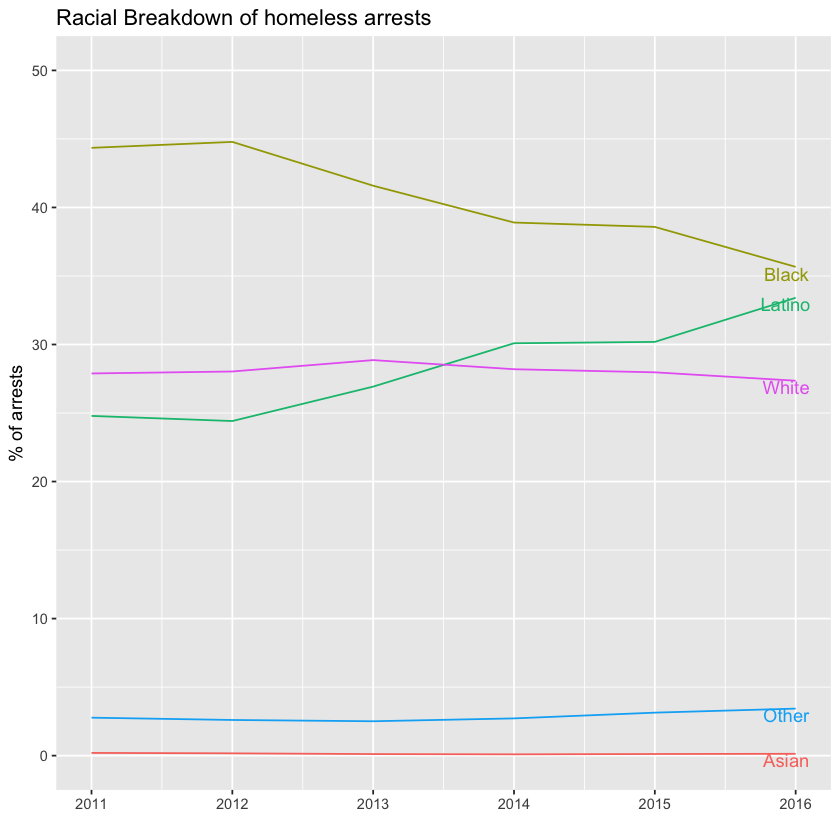

In [43]:
ggplot(arrests.race.yr %>% filter(homeless == 1 & arrest_year != 2017), aes(x = arrest_year, 
                                                                            y = arrests_percent, color = race.grp)) +
  geom_line() +
  geom_text(data = arrests.race.yr %>% filter(homeless == 1 & 
                                              arrest_year == 2016), aes(label = race.grp), hjust = 0.7,
            vjust = 1) +
  scale_y_continuous(limits = c(0, 50)) +
  labs(x = "", y = "% of arrests", title = "Racial Breakdown of homeless arrests") +
  theme(legend.position = 'none')

### Finding: In 2011, one in 10 people arrests citywide were of homeless people; in 2016, it was 1 in 6

Use the grouped dataframe `arrest.totals` to calculate percentage of homeless arrests by year

In [44]:
arrest.totals %>% 
    mutate(arrests_percent = arrests_number / sum(arrests_number) * 100) %>%
    filter(homeless == 1)

arrest_year,homeless,arrests_number,arrests_percent
2011,1,10496,10.85408
2012,1,11837,11.69271
2013,1,12237,12.47070
2014,1,12622,13.41667
2015,1,13418,15.41112
2016,1,14011,16.75797


### Finding: The 14,000 arrests of homeless people in 2016 included more than 500 unique charges

Filter the data to include homeless arrests in 2016 and calculate the number and percent of times each charge was cited. Note that this is done by analyzing each charge separately, so the `times_cited` column will not sum to the total number of arrests per year (arrestees can have multiple charges).

In [45]:
arrest.reasons <- data %>% filter(homeless == 1 & arrest_year == 2016) %>% 
                           group_by(charge_code, charge_desc) %>% 
                           summarize(times_cited = n()) %>% 
                           ungroup() %>% 
                           mutate(percent_cited = times_cited/sum(times_cited) * 100)

Get the number of unique charges

In [46]:
length(unique(arrest.reasons$charge_code))

[1] 523

### Finding: The most common offense was failure to appear in court for unpaid petty or minor citations

Sort by percent of the time the charge was cited to get the top charges

In [47]:
head(arrest.reasons %>% arrange(desc(percent_cited)))

charge_code,charge_desc,times_cited,percent_cited
853.7PC,fta-after-written-promise,4447,21.145982
11377(A)HS,possession-controlled-substance,924,4.393723
459.5PC,,674,3.204945
3000.08CPC,,613,2.914883
3454(C)PC,,579,2.753210
245(A)(1)PC,adw-wo-firearmgbi,530,2.520209


Many codes did not come with charge descriptions in the data. Those that appear in the above table are described as follows:

* 459.5PC: shoplifting
* 3000.08CPC: parole warrant
* 3454(C)PC: flash incarceration

### Finding: The top five charges were for non-violent or minor offenses

Some charge codes are grouped, largely according to [this](http://milliondollarhoods.org/wp-content/uploads/2017/10/Policing-the-House-2.0.FINAL_.pdf) UCLA report. For example. charge codes 40508(A)VC, 853.7PC, and 853.8PC all cover failure to appear.

In [48]:
arrest.reasons$failure <- ifelse(arrest.reasons$charge_code == '40508(A)VC'|
                                 arrest.reasons$charge_code == '853.7PC'|
                                 arrest.reasons$charge_code == '853.8PC', 1, 0)

arrest.reasons$trespass <- ifelse(arrest.reasons$charge_code == '419PC'|
                                  arrest.reasons$charge_code == '602(K)PC'|
                                  arrest.reasons$charge_code == '602(O)(2)PC'|
                                  arrest.reasons$charge_code == '602.5(A)PC'|
                                  arrest.reasons$charge_code == '555PC'|
                                  arrest.reasons$charge_code == '484F(A)PC'|
                                  arrest.reasons$charge_code == '602(L)(1)PC'|
                                  arrest.reasons$charge_code == '602(P)PC'|
                                  arrest.reasons$charge_code == '602.5(B)PC'|
                                  arrest.reasons$charge_code == '602PC'|
                                  arrest.reasons$charge_code == '602(M)PC'|
                                  arrest.reasons$charge_code == '602(Q)PC'|
                                  arrest.reasons$charge_code == '602.8PC'|
                                  arrest.reasons$charge_code == '602(A)PC'|
                                  arrest.reasons$charge_code == 'A602(N)1PC'|
                                  arrest.reasons$charge_code == '602(S)PC'|
                                  arrest.reasons$charge_code == '626.8(A)1PC'|
                                  arrest.reasons$charge_code == '602(D)PC'|
                                  arrest.reasons$charge_code == '602(N)PC'|
                                  arrest.reasons$charge_code == '602(U)(1)PC'|
                                  arrest.reasons$charge_code == '647(E)PC'|
                                  arrest.reasons$charge_code == '602(F)PC'|
                                  arrest.reasons$charge_code == '602(O)PC'|
                                  arrest.reasons$charge_code == '602.1(A)PC'| 
                                  arrest.reasons$charge_code == '647(H)PCLPP'| 
                                  arrest.reasons$charge_code == '602(J)PC'| 
                                  arrest.reasons$charge_code == '602(O)(1)PC'| 
                                  arrest.reasons$charge_code == '602.1(B)PC'| 
                                  arrest.reasons$charge_code == '369I(A)PC', 1, 0)

arrest.reasons$shoplift <- ifelse(arrest.reasons$charge_code == '18 1708'|
                                  arrest.reasons$charge_code == '484PCTFMV'|
                                  arrest.reasons$charge_code == '485PC'|
                                  arrest.reasons$charge_code == '488PC'|
                                  arrest.reasons$charge_code == '459.5PC'|
                                  arrest.reasons$charge_code == '484F(A)PC'|
                                  arrest.reasons$charge_code == 'A488PC'|
                                  arrest.reasons$charge_code == '490PC'|
                                  arrest.reasons$charge_code == 'A484PC'|
                                  arrest.reasons$charge_code == '484E(D)PC'|
                                  arrest.reasons$charge_code == '666PC'|
                                  arrest.reasons$charge_code == '484PC'|
                                  arrest.reasons$charge_code == '490.2PC'|
                                  arrest.reasons$charge_code == '666(A)PC'|
                                  arrest.reasons$charge_code == '484(A)PC'|
                                  arrest.reasons$charge_code == '490.5(A)PC'|
                                  arrest.reasons$charge_code == '537(A)(1)PC'|
                                  arrest.reasons$charge_code == '666.5PC'|
                                  arrest.reasons$charge_code == '484E(A)PC'|
                                  arrest.reasons$charge_code == '587CPC'|
                                  arrest.reasons$charge_code == '666.5(A)PC'|
                                  arrest.reasons$charge_code == '484E(B)PC', 1, 0)

arrest.reasons$supervision_viol <- ifelse(arrest.reasons$charge_code == '1203.2PC'|
                                          arrest.reasons$charge_code == '3000.08CPC'|
                                          arrest.reasons$charge_code == '3454(C)PC'| 
                                          arrest.reasons$charge_code == '3455(B)1PC'|
                                          arrest.reasons$charge_code == '1203.2(A)PC'|
                                          arrest.reasons$charge_code == '3056PC'|
                                          arrest.reasons$charge_code == '3455(A)4PC'|
                                          arrest.reasons$charge_code == '3455(C)PC'|
                                          arrest.reasons$charge_code == '3000.08FPC'|
                                          arrest.reasons$charge_code == '3454PC'|
                                          arrest.reasons$charge_code == '3455(A)PC'|
                                          arrest.reasons$charge_code == '18 3606US', 1, 0)

arrest.reasons$drug_poss <- ifelse(arrest.reasons$charge_code == '11377(A)HS'|
                                   arrest.reasons$charge_code == '11377(A)1HS'|
                                   arrest.reasons$charge_code == '11377HS'| 
                                   arrest.reasons$charge_code == '11350(A)HS'|
                                   arrest.reasons$charge_code == '11350HS'|
                                   arrest.reasons$charge_code == '11357HS'|
                                   arrest.reasons$charge_code == '11357(A)HS'|
                                   arrest.reasons$charge_code == '11357(B)HS'|
                                   arrest.reasons$charge_code == '11357(C)HS'|
                                   arrest.reasons$charge_code == '4573.6PC'|
                                   arrest.reasons$charge_code == '11550(A)HS'|
                                   arrest.reasons$charge_code == '11375(B)2HS'|
                                   arrest.reasons$charge_code == '11351HS'|
                                   arrest.reasons$charge_code == '4060BP', 1, 0)

arrest.reasons$charge_desc_grouped <- ifelse(arrest.reasons$drug_poss == 1, 'drug_poss',
                                             ifelse(arrest.reasons$trespass == 1, 'trespass',
                                                    ifelse(arrest.reasons$shoplift == 1, 'shoplift',
                                                           ifelse(arrest.reasons$supervision_viol == 1, 'supervision violation',
                                                                  ifelse(arrest.reasons$failure == 1, 'failure to appear',
                                                                         arrest.reasons$charge_code)))))

Get top five offenses using `charge_desc_grouped` as the charge identifier

In [49]:
arrest.reasons %>% group_by(charge_desc_grouped) %>% 
    summarise(times_cited = sum(times_cited)) %>% 
    mutate(perc_cited = times_cited/sum(times_cited) * 100) %>% arrange(desc(times_cited)) %>% head(5)

charge_desc_grouped,times_cited,perc_cited
failure to appear,4576,21.759391
drug_poss,2147,10.209225
supervision violation,2085,9.914408
shoplift,1650,7.845934
trespass,1056,5.021398
